In [1]:
import glob
import math
import datetime
import json
import itertools
from pathlib import Path

import numpy as np
import pandas as pd
import scipy
import librosa as lbr
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from sklearn import metrics
from sklearn.utils.multiclass import unique_labels
from tqdm import tqdm

# Accuracy

In [2]:
lstm_metrics_files = glob.glob("../reports/marron1/lstm-2/cv/*/metrics*.json")
esn_metrics_files = glob.glob("../reports/marron1/esn-4/cv/*/metrics*.json")

In [3]:
len(lstm_metrics_files), len(esn_metrics_files)

(25, 150)

In [4]:
all_lstm_metrics = []
for m in lstm_metrics_files:
    with open(m, "r") as fp:
        all_lstm_metrics.append(json.load(fp))
        
all_esn_metrics = []
for m in esn_metrics_files:
    with open(m, "r") as fp:
        all_esn_metrics.append(json.load(fp))

In [5]:
def get_esn_instances(x):
    instance = Path(x).stem.split("-")[1]
    return instance

esn_instances_metrics = {str(i): [] for i in range(30)}
for m in esn_metrics_files:
    instance = get_esn_instances(m)
    with open(m, "r") as fp:
        met = json.load(fp)
    esn_instances_metrics[instance].append(met)

In [6]:
lstm_accuracies = []
for met in all_lstm_metrics:
    lstm_accuracies += [m["accuracy"] for m in met.values()]
    
esn_accuracies = []
for met in all_esn_metrics:
    esn_accuracies += [m["accuracy"] for m in met.values()]

mean_lstm_accuracy = np.mean(lstm_accuracies)
median_lstm_accuracy = np.median(lstm_accuracies)
std_lstm_accuracy = np.std(lstm_accuracies)


mean_esn_accuracy = np.mean(esn_accuracies)
median_esn_accuracy = np.median(esn_accuracies)
std_esn_accuracy = np.std(esn_accuracies)

In [7]:
w, p = scipy.stats.mannwhitneyu(esn_accuracies, lstm_accuracies)
w, p

(10016240.0, 0.2806418022251993)

In [8]:
mean_lstm_accuracy, std_lstm_accuracy, median_lstm_accuracy

(0.931350163323935, 0.10439287582142792, 0.9509172037679723)

In [9]:
mean_esn_accuracy, std_esn_accuracy, median_esn_accuracy

(0.9349578700711627, 0.09275546385545755, 0.951487414187643)

In [19]:
tlstm_metrics_files = glob.glob("../reports/marron1/lstm-2/complete/metrics*.json")
tesn_metrics_files = glob.glob("../reports/marron1/esn-4/complete/metrics*.json")

In [20]:
tall_lstm_tmetrics = []
for m in tlstm_metrics_files:
    with open(m, "r") as fp:
        tall_lstm_tmetrics.append(json.load(fp))
        
tall_esn_tmetrics = []
for m in tesn_metrics_files:
    with open(m, "r") as fp:
        tall_esn_tmetrics.append(json.load(fp))

In [21]:
tlstm_taccuracies = []
for met in tall_lstm_tmetrics:
    tlstm_taccuracies += [m["accuracy"] for m in met.values()]
    
tesn_taccuracies = []
for met in tall_esn_tmetrics:
    tesn_taccuracies += [m["accuracy"] for m in met.values()]

tmean_lstm_accuracy = np.mean(tlstm_taccuracies)
tmedian_lstm_accuracy = np.median(tlstm_taccuracies)
tstd_lstm_accuracy = np.std(tlstm_taccuracies)


tmean_esn_accuracy = np.mean(tesn_taccuracies)
tmedian_esn_accuracy = np.median(tesn_taccuracies)
tstd_esn_accuracy = np.std(tesn_taccuracies)

In [23]:
w, p = scipy.stats.mannwhitneyu(tesn_taccuracies, tlstm_taccuracies)
w, p

(534682.5, 2.924155016355841e-08)

In [24]:
tmean_lstm_accuracy, tstd_lstm_accuracy, tmedian_lstm_accuracy

(0.939468883888477, 0.10238891025565672, 0.9593823715551464)

In [25]:
tmean_esn_accuracy, tstd_esn_accuracy, tmedian_esn_accuracy

(0.944533451749361, 0.02691797835826046, 0.9540010432494304)

# WER

In [8]:
import itertools
from collections import Counter

def group(seq, min_frame_nb=0, exclude=("SIL", "TRASH")):
    """
    Group all consecutive equivalent labels in a discrete
    time sequence into a single label,
    with number of frames grouped attached. All groups of
    consecutive predictions
    composed of N < min_frame_nb items will be removed.
    """
    # first grouping
    newseq = [s for s in seq if s not in exclude]
    newseq = [list(g) for k, g in itertools.groupby(newseq)]
    newseq = [rseq for rseq in newseq
              if len(rseq) >= min_frame_nb]

    newseq = flatten(newseq)

    grouped_sequence = [(k, len(list(g))) for k, g in itertools.groupby(newseq)]

    return grouped_sequence


def majority_vote(seq, win_length=1, exclude=("SIL", "TRASH")):

    ss = [s for s in seq if s not in exclude]

    # majority vote over sliding windows
    new_seq = []
    for win in ngrams(seq, win_length):
        counts = Counter(win).most_common()
        new_seq.append(counts[0][0])

    return new_seq


def lev_dist(s, t):
    """
    Levenshtein distance between two sequences S and T.
    Returns the minimum number of operations (insertions, substitutions, deletions)
    to perform to perfectly match S and T.
    """

    v0 = np.arange(len(t)+1)
    v1 = np.zeros(len(t)+1)

    for i in range(0, len(s)):
        v1[0] = i + 1

        for j in range(0, len(t)):
            delcost = v0[j+1] + 1  # deletions
            incost = v1[j] + 1  # insertions
            if s[i] == t[j]:
                subcost = v0[j]  # substitutions
            else:
                subcost = v0[j] + 1

            v1[j + 1] = min([delcost, incost, subcost])

        v0, v1 = v1, v0

    return v0[len(t)]


def word_error_rate(true, pred):

    edit_dist = lev_dist(pred, true)

    return edit_dist / len(true)


def flatten(lists):
    """
    Flatten a list of lists into a simple list.
    """
    flat = []
    for ls in lists:
        for e in ls:
            flat.append(e)
    return flat


def ngrams(seq, n=1):
    """
    Generate ngrams from a sequence.
    """
    for i in range(len(seq)-n+1):
        yield tuple(seq[i:i+n])


In [9]:
song_data = glob.glob("../data/marron1/data/*.csv")

dfs = []
for song_file in song_data:
    dfs.append(pd.read_csv(song_file))
    
correction_file = glob.glob("../data/marron1/*correction*")
with open(correction_file[0], "r") as fp:
    corrections = json.load(fp)

joined = []
for df in dfs:
    df.replace(to_replace=corrections["syll"], inplace=True)
    
    df['diff'] = df["start"] - df.shift()["end"]

    first_consecutives = df[(df["syll"].shift(-1) == df["syll"])
                            & ~(df["syll"].isin(["cri", "TRASH"]))
                            & (df["diff"] < 0.5)]

    last_consecutives = df.loc[first_consecutives.index + 1]
    
    new_ends = df.loc[last_consecutives.index, "end"].values
    df.at[first_consecutives.index, "end"] = new_ends
    df = df.drop(last_consecutives.index, axis=0).reset_index(drop=True)
    df.drop(['diff'], axis=1, inplace=True)
    
    df.drop(df[df["syll"] == "DELETE"].index, inplace=True, axis=0)
    
    joined.append(df)

df = pd.concat(joined)
df["duration"] = df["end"] - df["start"]
min_phrase_len = round(df["duration"].min() * 44100 / 512)
min_avg_phrase_len = round(df.groupby("syll")["duration"].mean().min() * 44100 / 512)

df_notrash = df[df["syll"] != "TRASH"]
min_percent_len = round(df_notrash[df_notrash["duration"] <= df_notrash.quantile(.01)["duration"]])

In [10]:
df_notrash[df_notrash["duration"] <= 0.046]

,wave,start,end,syll,repertoire_file,duration
6,208_marron1_May_29_2016_48178338.wav,7.348470,7.392325,J2,J3-324068-326002-208_marron1_May_29_2016_48178338,0.043855
14,471_marron1_May_23_2016_67423776.wav,15.826000,15.867000,J2,J3-697927-699735-471_marron1_May_23_2016_67423776,0.041000
32,106_marron1_May_25_2016_22908212.wav,22.855000,22.894000,J2,J3-1007906-1009626-106_marron1_May_25_2016_229...,0.039000
37,106_marron1_May_25_2016_22908212.wav,25.460680,25.506000,J1,Ji-1122816-1124815-106_marron1_May_25_2016_229...,0.045320
17,522_marron1_June_07_2016_64188680.wav,17.852951,17.896953,J2,J3-787316-789256-522_marron1_June_07_2016_6418...,0.044002
3,547_marron1_June_15_2016_57686110.wav,6.030574,6.063679,J2,J3-265949-267409-547_marron1_June_15_2016_5768...,0.033105
3,387_marron1_June_13_2016_59006195.wav,6.407000,6.447000,J2,J3-282549-284313-387_marron1_June_13_2016_5900...,0.040000


In [29]:
min_percent_lengths = (min_percent_len["duration"] * 44100 / 512).values

In [30]:
lstm_wers = []
for met in all_lstm_metrics:
    wer = np.array([list(m["wer"].values()) for m in met.values()])
    lstm_wers.append(wer)
    
esn_wers = []
for met in all_esn_metrics:
    wer = np.array([list(m["wer"].values()) for m in met.values()])
    esn_wers.append(wer)

lstm_wers = np.vstack(lstm_wers)
mean_lstm_wers = lstm_wers.mean(axis=0)[1:]
std_lstm_wers = lstm_wers.std(axis=0)[1:]

esn_wers = np.vstack(esn_wers)
mean_esn_wers = esn_wers.mean(axis=0)[1:]
std_esn_wers = esn_wers.std(axis=0)[1:]

In [31]:
esn_wers

array([[0.86363636, 0.86363636, 0.86363636, ..., 0.86363636, 0.86363636,
        0.86363636],
       [0.92592593, 0.92592593, 0.92592593, ..., 0.88888889, 0.88888889,
        0.88888889],
       [0.78125   , 0.78125   , 0.78125   , ..., 0.84375   , 0.84375   ,
        0.84375   ],
       ...,
       [0.9047619 , 0.9047619 , 0.9047619 , ..., 0.85714286, 0.85714286,
        0.85714286],
       [1.4       , 1.4       , 1.4       , ..., 1.        , 1.        ,
        1.        ],
       [0.76      , 0.76      , 0.76      , ..., 0.8       , 0.8       ,
        0.8       ]])

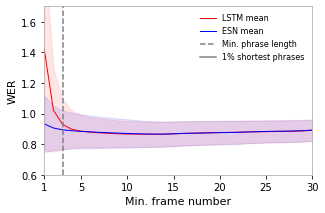

In [32]:
fig = plt.figure(figsize=(4.8, 3.1))

plt.plot(np.arange(len(mean_lstm_wers)) + 1, mean_lstm_wers, color="red", lw=1, label="LSTM mean")
plt.ylabel("WER", size=11)
plt.xlabel("Min. frame number", size=11)
plt.fill_between(np.arange(len(mean_lstm_wers)) + 1, mean_lstm_wers + std_lstm_wers, mean_lstm_wers - std_lstm_wers, 
                 alpha=0.1, color="red")

plt.plot(np.arange(len(mean_lstm_wers)) + 1, mean_esn_wers, color="blue", lw=1, label="ESN mean")
plt.ylabel("WER", size=11)
plt.xlabel("Min. frame number", size=11)
plt.fill_between(np.arange(len(mean_esn_wers)) + 1, mean_esn_wers + std_esn_wers, mean_esn_wers - std_esn_wers, 
                 alpha=0.1, color="blue", label="")

plt.axvline(min_phrase_len, linestyle="--", color="gray", label="Min. phrase length")

for i, v in enumerate(min_percent_lengths):
    if i == 0:
        plt.axvline(v, alpha=1, zorder=0, color="gray", label="1% shortest phrases")
        continue
    plt.axvline(v, alpha=0.1, zorder=0, color="gray")

plt.legend(frameon=False, fontsize=8)

plt.ylim(0.6, 1.7)
plt.xlim(1, 30)

plt.xticks([1, 5, 10, 15, 20, 25, 30])
plt.tick_params(axis="both", labelsize=10)

plt.savefig("../figures/wer.pdf")
plt.savefig("../figures/wer.png")

# F1 + confusion

## LSTM

In [25]:
lstm_pred_files = glob.glob("../reports/marron1/lstm-2/cv/*/preds*/*.npz")
esn_pred_files = glob.glob("../reports/marron1/esn-4/cv/*/preds*/*.npz")

lstm_red_files = glob.glob("../reports/marron1/lstm-2/reduced/*/preds*/*.npz")
esn_red_files = glob.glob("../reports/marron1/esn-4/reduced/*/preds*/*.npz")

len(lstm_pred_files), len(esn_pred_files), len(lstm_red_files), len(esn_red_files)

(1835, 11010, 6460, 16560)

In [26]:
y_lstm = []
yh_lstm = []
for m in lstm_pred_files:
    data = np.load(m)
    y = data["targets"]
    yh = data["top_1"]
    yh_lstm.append(yh)
    y_lstm.append(y)
    
y_esn = []
yh_esn = []
for m in esn_pred_files:
    data = np.load(m)
    y = data["targets"]
    yh = data["top_1"]
    yh_esn.append(yh)
    y_esn.append(y)

In [27]:
print(metrics.classification_report(np.hstack(y_lstm), np.hstack(yh_lstm), digits=4))

              precision    recall  f1-score   support

           A     0.9687    0.9675    0.9681    268160
          B1     0.9392    0.9504    0.9448    253090
          B2     0.9261    0.9505    0.9381    250820
           C     0.9619    0.9540    0.9580    140545
          Ci     0.8751    0.8516    0.8632     36190
           D     0.9651    0.9598    0.9625    105215
           E     0.9602    0.9631    0.9617    178825
           H     0.9291    0.9361    0.9326     82850
           I     0.8810    0.7890    0.8325     18160
          J1     0.9454    0.9347    0.9400    301175
          J2     0.9323    0.9264    0.9294    277165
           K     0.9062    0.9109    0.9085     38970
          K2     0.8891    0.8941    0.8916     23230
           L     0.9598    0.9711    0.9654    137690
          L2     0.8265    0.0489    0.0924      1655
           M     0.9713    0.9721    0.9717    118160
           N     0.9660    0.9755    0.9707    468195
           O     0.9012    

In [46]:
lstm_accs_nosil = []
for i in range(len(y_lstm)):
    idx = ~(y_lstm[i] == "SIL") & ~(y_lstm[i] == "cri") & ~(y_lstm[i] == "TRASH")
    lstm_accs_nosil.append(metrics.accuracy_score(y_lstm[i][idx], yh_lstm[i][idx]))
    
esn_accs_nosil = []
for i in range(len(y_esn)):
    idx = ~(y_esn[i] == "SIL") & ~(y_esn[i] == "cri") & ~(y_esn[i] == "TRASH")
    esn_accs_nosil.append(metrics.accuracy_score(y_esn[i][idx], yh_esn[i][idx]))

In [47]:
np.mean(lstm_accs_nosil), np.mean(esn_accs_nosil)

(0.9411291690635006, 0.9470255170785017)

In [48]:
np.std(lstm_accs_nosil), np.std(esn_accs_nosil)

(0.1090525010712733, 0.09813200851537904)

In [55]:
lstm_trans = []
for i in range(len(yh_lstm)):
    s_trans = 0
    for j in range(1, len(yh_lstm[i])):
        if yh_lstm[i][j-1] != yh_lstm[i][j]:
            s_trans += 1
    lstm_trans.append(s_trans)

In [57]:
np.mean(lstm_trans), np.std(lstm_trans)

(73.06430517711172, 34.77706667053152)

In [60]:
esn_trans = []
for i in range(len(yh_esn)):
    s_trans = 0
    for j in range(1, len(yh_esn[i])):
        if yh_esn[i][j-1] != yh_esn[i][j]:
            s_trans += 1
    esn_trans.append(s_trans)

In [61]:
np.mean(esn_trans), np.std(esn_trans)

(48.083560399636696, 22.288568862684397)

In [28]:
lstm_wers = []
for yy, yyh in zip(tqdm(y_lstm), yh_lstm):
    yh = group(yy, exclude=("SIL", "TRASH", "cri"))
    yhlbl = [u[0] for u in yh]
    y = group(yyh, exclude=("SIL", "TRASH", "cri"))
    ylbl = [u[0] for u in y]
    lstm_wers.append(word_error_rate(ylbl, yhlbl))

100%|██████████| 1835/1835 [00:07<00:00, 240.01it/s]


In [29]:
lstm_global_mean_wer = np.mean(lstm_wers)
lstm_global_std_wer = np.std(lstm_wers)

lstm_global_mean_wer, lstm_global_std_wer

(0.27383075255744405, 0.16184723908057264)

In [30]:
print(metrics.classification_report(np.hstack(y_esn), np.hstack(yh_esn), digits=4))

/home/nathan/Bureau/canary/canary-decoder-paper/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/nathan/Bureau/canary/canary-decoder-paper/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           A     0.9745    0.9704    0.9725   1525170
          B1     0.9455    0.9589    0.9522   1482870
          B2     0.9281    0.9610    0.9443   1463700
           C     0.9731    0.9542    0.9635    818190
          Ci     0.9157    0.8494    0.8813    211650
           D     0.9423    0.9706    0.9562    643950
           E     0.9532    0.9710    0.9620   1036800
           H     0.9341    0.9337    0.9339    489210
           I     0.9496    0.7927    0.8641    107970
          J1     0.9573    0.9346    0.9458   1756980
          J2     0.9371    0.9308    0.9340   1560810
           K     0.9230    0.8939    0.9082    231270
          K2     0.9055    0.9192    0.9123    139470
           L     0.9611    0.9782    0.9696    825840
          L2     0.9090    0.1297    0.2270      9930
           M     0.9772    0.9772    0.9772    715200
           N     0.9665    0.9785    0.9724   2683440
           O     0.8918    

/home/nathan/Bureau/canary/canary-decoder-paper/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [31]:
esn_wers = []
for yy, yyh in zip(tqdm(y_esn), yh_esn):
    yh = group(yy, exclude=("SIL", "TRASH", "cri"))
    yhlbl = [u[0] for u in yh]
    y = group(yyh, exclude=("SIL", "TRASH", "cri"))
    ylbl = [u[0] for u in y]
    esn_wers.append(word_error_rate(ylbl, yhlbl))

100%|██████████| 11010/11010 [00:34<00:00, 321.98it/s]


In [32]:
esn_global_mean_wer = np.mean(esn_wers)
esn_global_std_wer = np.std(esn_wers)

esn_global_mean_wer, esn_global_std_wer

(0.05334323556654554, 0.07228358656082542)

In [160]:
yhs = []
ys = []
for m in pred_files:
    data = np.load(m)
    yh = data["top_1"]
    y = data["targets"]
    
    yhs.extend(yh)
    ys.extend(y)

In [164]:
syllables = unique_labels(ys)
cm = metrics.confusion_matrix(ys, yhs, labels=syllables, normalize="true")

In [116]:
def confusion(cm, syllables):
    fig = plt.figure(figsize=(7, 7))
    
    ax1 = fig.add_subplot(111)
    plt.xlabel("Predictions", fontsize=11)
    plt.ylabel("Truths", fontsize=11)
    ax1.xaxis.set_label_position('top') 
    im = ax1.matshow(cm, cmap="Blues", norm=matplotlib.colors.LogNorm(vmin=1e-3, vmax=1.0))

    ax1.set_xticks(np.arange(len(syllables)))
    ax1.set_yticks(np.arange(len(syllables)))

    ax1.set_xticklabels(syllables)
    ax1.set_yticklabels(syllables)
    ax1.tick_params('x', top=True, bottom=False, labeltop=True, labelbottom=False, rotation=45)
    ax1.tick_params(labelsize=11)
    
    
    axins = inset_axes(ax1,
                       width="5%",  # width = 5% of parent_bbox width
                       height="100%",  # height : 50%
                       loc='lower left',
                       bbox_to_anchor=(1.005, 0., 1, 1),
                       bbox_transform=ax1.transAxes,
                       borderpad=0,
                       )
    
    axins.tick_params(labelsize=10)
    
    plt.colorbar(im, cax=axins)
    
    plt.tight_layout()
    
    return fig

<ipython-input-116-b43afc7d63a4>:32: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


<Figure size 432x288 with 0 Axes>

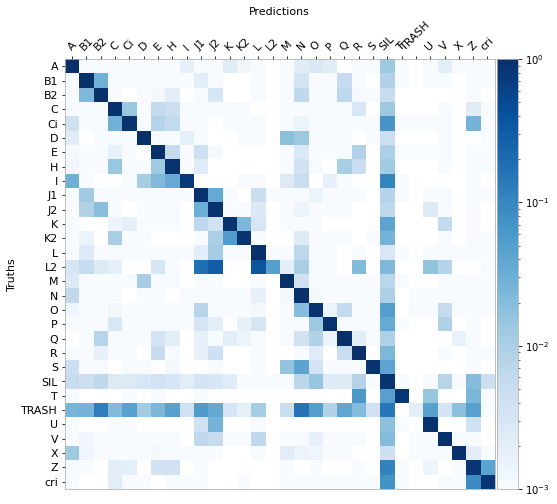

In [117]:
plt.clf()
fig = confusion(cm, syllables)
fig.savefig("../figures/lstm-confusion.pdf")
fig.savefig("../figures/lstm-confusion.png")

In [118]:
f1 = metrics.f1_score(ys, yhs, average="macro")

In [119]:
f1

0.8671043881458025

## LSTM time

In [120]:
time_files = glob.glob("../reports/marron1/lstm-2/cv/*/duration*")

In [121]:
all_durations = []
for m in time_files:
    with open(m, "r") as fp:
        all_durations.append(json.load(fp)["duration"])

In [122]:
dur = np.mean(all_durations)
std_dur = np.std(all_durations)
dur, std_dur

(2930.2318060588836, 222.81647784144985)

In [123]:
epochs = np.array([ # copied from Tensorboard logs
    194, 178, 292, 205, 270, 164, 135, 218, 220, 175, 224, 218,
    146, 225, 231, 152, 230, 202, 164, 225, 210, 191, 194, 175, 198]) - 20 # minus patience
 
len(epochs)

25

In [124]:
np.mean(epochs), np.std(epochs)

(181.44, 35.835267544696805)

## ESN

In [3]:
pred_files = glob.glob("../reports/marron1/esn-4/cv/*/preds*/*.npz")

In [4]:
yhs = []
ys = []
for m in pred_files:
    data = np.load(m)
    yh = data["top_1"]
    y = data["targets"]
    
    yhs.append(yh)
    ys.append(y)

In [11]:
min_frames = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30]
all_wers = []
for i in min_frames:
    print(i)
    wers = []
    for yy, yyh in zip(tqdm(ys), yhs):
        #yh = majority_vote(yyh, win_length=1)
        yh = group(yy, min_frame_nb=i, exclude=("SIL", "TRASH", "cri"))
        yhlbl = [u[0] for u in yh]
        #y = majority_vote(yy, win_length=1)
        y = group(yyh, exclude=("SIL", "TRASH", "cri"))
        ylbl = [u[0] for u in y]

        wers.append(word_error_rate(ylbl, yhlbl))
    all_wers.append(wers)

  0%|          | 40/11010 [00:00<00:55, 196.88it/s]

1


  0%|          | 28/11010 [00:00<00:41, 265.41it/s]

2


  0%|          | 28/11010 [00:00<00:42, 257.52it/s]

3


  0%|          | 28/11010 [00:00<00:43, 254.02it/s]

4


  0%|          | 28/11010 [00:00<00:42, 259.02it/s]

5


  0%|          | 28/11010 [00:00<00:42, 259.43it/s]

6


  0%|          | 28/11010 [00:00<00:42, 260.57it/s]

7


  0%|          | 28/11010 [00:00<00:41, 265.70it/s]

8


  0%|          | 28/11010 [00:00<00:41, 263.68it/s]

9


  0%|          | 28/11010 [00:00<00:40, 268.92it/s]

10


  0%|          | 29/11010 [00:00<00:38, 282.76it/s]

15


  1%|          | 60/11010 [00:00<00:39, 280.48it/s]

20


  1%|          | 60/11010 [00:00<00:38, 283.67it/s]

25


  1%|          | 62/11010 [00:00<00:38, 287.28it/s]

30


100%|██████████| 11010/11010 [00:29<00:00, 374.96it/s]


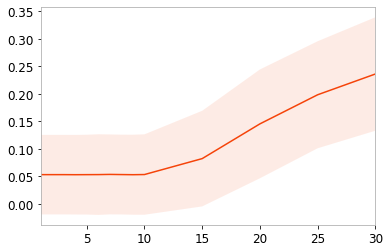

In [12]:
wer_means = np.mean(all_wers, axis=1)
wer_stds = np.std(all_wers, axis=1)

plt.plot(min_frames, wer_means)
plt.fill_between(min_frames, wer_means - wer_stds, wer_means + wer_stds, alpha=0.1)

In [ ]:
palette = itertools.cycle(plt.get_cmap("tab10").colors)
colors = {"SIL": "white"}

tcursor = 0
pcursor = 0
for t in y:
    
    c = colors.get(t[0], next(palette))
    colors[t[0]] = c
    
    plt.hlines(0.2, tcursor, tcursor+t[1], color=c, lw=40)
    tcursor += t[1]

for p in yh:
    
    c = colors.get(p[0], next(palette))
    colors[p[0]] = c
    
    plt.hlines(-0.2, pcursor, pcursor+p[1], color=c, lw=40)
    pcursor += p[1]

In [162]:
yhs = []
ys = []
for m in pred_files:
    data = np.load(m)
    yh = data["top_1"]
    y = data["targets"]
    
    yhs.extend(yh)
    ys.extend(y)

In [163]:
syllables = unique_labels(ys)
cm = metrics.confusion_matrix(ys, yhs, labels=syllables, normalize="true")

<ipython-input-116-b43afc7d63a4>:32: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


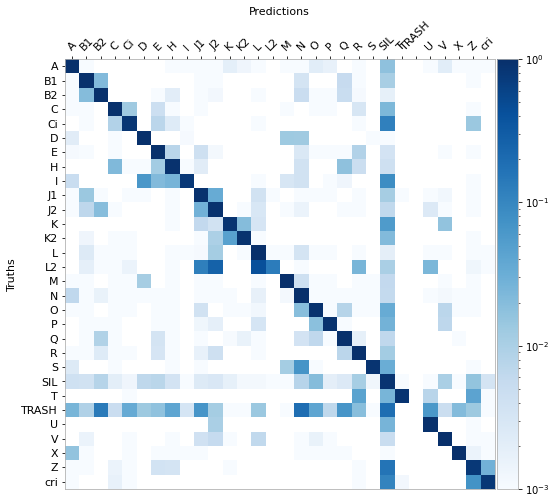

In [164]:
fig = confusion(cm, syllables)
fig.savefig("../figures/esn-confusion.pdf")
fig.savefig("../figures/esn-confusion.png")

In [165]:
f1 = metrics.f1_score(ys, yhs, average="macro")

In [166]:
f1

0.8775507157980319

## ESN time

In [78]:
time_files = glob.glob("../reports/marron1/esn-3/cv/*/duration*")

In [79]:
all_durations = []
for m in time_files:
    with open(m, "r") as fp:
        all_durations.append(json.load(fp)["duration"])

In [80]:
dur = np.mean(all_durations)
std_dur = np.std(all_durations)
dur, std_dur

(35.257997450828555, 1.0761012842977704)

# Reduced training dataset

In [17]:
lstm_rfiles = []
esn_rfiles = []
for i in [5, 10, 20, 30, 50, 70]:
    lstm_rfiles.append(glob.glob(f"../reports/marron1/lstm-2/reduced/{i}/metrics-[0-9].json"))
    esn_rfiles.append(glob.glob(f"../reports/marron1/esn-4/reduced/{i}/metrics-[0-9][0-9].json") + 
                      glob.glob(f"../reports/marron1/esn-4/reduced/{i}/metrics-[0-9].json"))

lstm_trfiles = []
esn_trfiles = []
for i in [5, 10, 20, 30, 50, 70]:
    lstm_trfiles.append(glob.glob(f"../reports/marron1/lstm-2/reduced/{i}/metrics-train-[0-9].json"))
    esn_trfiles.append(glob.glob(f"../reports/marron1/esn-4/reduced/{i}/metrics-train-[0-9][0-9].json") + 
                      glob.glob(f"../reports/marron1/esn-4/reduced/{i}/metrics-train-[0-9].json"))
    
esn_time_files = glob.glob("../reports/marron1/esn-4/reduced/*/duration*")
lstm_time_files = glob.glob("../reports/marron1/lstm-2/reduced/*/duration*")

esn_time_files = sorted(esn_time_files, key=lambda x: int(Path(x).parent.stem))
lstm_time_files = sorted(lstm_time_files, key=lambda x: int(Path(x).parent.stem))


lstm_pred_files = []
esn_pred_files = []
for i in [5, 10, 20, 30, 50, 70]:
    lstm_pred_files.append(glob.glob(f"../reports/marron1/lstm-2/reduced/{i}/preds-[0-9]/*.npz"))
    esn_pred_files.append(glob.glob(f"../reports/marron1/esn-4/reduced/{i}/preds-[0-9][0-9]/.*.npz") + 
                      glob.glob(f"../reports/marron1/esn-4/reduced/{i}/preds-[0-9]/*.npz"))

In [18]:
y_lstm = []
yh_lstm = []
for red in lstm_pred_files:
    y_red = []
    yh_red = []
    for m in red:
        data = np.load(m)
        y = data["targets"]
        yh = data["top_1"]
        yh_red.append(yh)
        y_red.append(y)
    y_lstm.append(y_red)
    yh_lstm.append(yh_red)

y_esn = []
yh_esn = []
for red in esn_pred_files:
    y_red = []
    yh_red = []
    for m in red:
        data = np.load(m)
        y = data["targets"]
        yh = data["top_1"]
        yh_red.append(yh)
        y_red.append(y)
    y_esn.append(y_red)
    yh_esn.append(yh_red)

In [19]:
durations = []
for y_red in y_esn:
    dur = []
    for yy in y_red:
        dur.append(len(yy) * 512 / 44100)
    durations.append(np.sum(dur))

In [20]:
len(y_esn)

6

In [21]:
lstm_wers = []
for y_red, yh_red in zip(y_lstm, yh_lstm):
    red_wer = []
    for yy, yyh in zip(tqdm(y_red), yh_red):
        yh = group(yy, exclude=("SIL", "TRASH", "cri"))
        yhlbl = [u[0] for u in yh]
        y = group(yyh, exclude=("SIL", "TRASH", "cri"))
        ylbl = [u[0] for u in y]
        red_wer.append(word_error_rate(ylbl, yhlbl))
    lstm_wers.append(red_wer)

100%|██████████| 460/460 [00:01<00:00, 234.72it/s]


In [22]:
esn_wers = []
for y_red, yh_red in zip(y_esn, yh_esn):
    red_wer = []
    for yy, yyh in zip(tqdm(y_red), yh_red):
        yh = group(yy, exclude=("SIL", "TRASH", "cri"))
        yhlbl = [u[0] for u in yh]
        y = group(yyh, exclude=("SIL", "TRASH", "cri"))
        ylbl = [u[0] for u in y]
        red_wer.append(word_error_rate(ylbl, yhlbl))
    esn_wers.append(red_wer)

100%|██████████| 920/920 [00:02<00:00, 318.59it/s]


In [23]:
lstm_wer_means = []
lstm_wer_stds = []
for red_wers in lstm_wers:
    lstm_wer_means.append(np.mean(red_wers))
    lstm_wer_stds.append(np.std(red_wers))

esn_wer_means = []
esn_wer_stds = []
for red_wers in esn_wers:
    esn_wer_means.append(np.mean(red_wers))
    esn_wer_stds.append(np.std(red_wers))

In [24]:
esn_wer_means.append(esn_global_mean_wer)
esn_wer_stds.append(esn_global_std_wer)

lstm_wer_means.append(lstm_global_mean_wer)
lstm_wer_stds.append(lstm_global_std_wer)

NameError: name 'esn_global_mean_wer' is not defined

In [ ]:
durations = np.load('../durations.npy') * 512 / 44100

tr_duration = np.load("../train-duration.npy") * 512 / 44100
te_duration = np.load("../test-duration.npy") * 512 / 41000

In [ ]:
mean_durations = np.round(np.mean(durations, axis=1)).astype(int).tolist()
mean_durations += [round(tr_duration)]
std_durations = np.round(np.std(durations, axis=1))
std_durations, mean_durations

In [ ]:
str(datetime.timedelta(seconds=1813)), str(datetime.timedelta(seconds=87))

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(4.8, 2.4), sharey=True)

x = [5, 10, 20, 30, 50, 70, 368]

ax1.grid()
ax2.grid()

ax1.plot(x, lstm_wer_means, label="LSTM", color="red", lw=1, marker="^", markersize=5)
ax1.fill_between(x, np.array(lstm_wer_means) - np.array(lstm_wer_stds), 
                 np.array(lstm_wer_means) + np.array(lstm_wer_stds), alpha=0.2)

ax1.plot(x, esn_wer_means, color="blue", marker="o", lw=1, markersize=5)
ax1.fill_between(x, np.array(esn_wer_means) - np.array(esn_wer_stds), 
                 np.array(esn_wer_means) + np.array(esn_wer_stds), alpha=0.2)

ax2.plot(x, lstm_wer_means, label="LSTM", color="red", lw=1, marker="^", markersize=5)
ax2.fill_between(x, np.array(lstm_wer_means) - np.array(lstm_wer_stds), 
                 np.array(lstm_wer_means) + np.array(lstm_wer_stds), alpha=0.2)


ax2.plot(x, esn_wer_means, color="blue", label="ESN", marker="o", lw=1, markersize=5)
ax2.fill_between(x, np.array(esn_wer_means) - np.array(esn_wer_stds), 
                 np.array(esn_wer_means) + np.array(esn_wer_stds), alpha=0.2)

ax1.set_xlim(0, 73) 
ax2.set_xlim(367, 368.1) 

ax1.set_ylim(0, 0.8)

ax1.set_xticks([5, 20, 50, 70])
ax1.set_xticklabels([mean_durations[i] for i in [0, 2, 4, 5]])
ax2.set_xticks([368])
ax2.set_xticklabels([mean_durations[-1]])

ax1.set_yticks(np.array([0.05, 0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75]))

ax1.spines["right"].set_visible(False)
ax2.spines["left"].set_visible(False)

kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax1.plot([1, 1], [0, 1], transform=ax1.transAxes, **kwargs)
ax2.plot([0, 0], [0, 1], transform=ax2.transAxes, **kwargs)

ax1.set_ylabel("WER", size=11)
ax1.set_xlabel("Training set (sec)", size=11)
ax2.set_xlabel("All train songs (sec)", size=11)

ax1.tick_params(which="both", axis="both", labelsize=10)
ax2.tick_params(which="both", axis="both", labelsize=10)

fig.tight_layout()

ax2.legend(fontsize=8)

fig.savefig("../figures/reduced_song_wer.pdf")
fig.savefig("../figures/reduced_song_wer.png")

In [ ]:
te_duration

In [ ]:
str(datetime.timedelta(seconds=2495))

In [ ]:
lstm_rmet = []
for red in lstm_rfiles:
    red_mets = []
    for m in red:
        with open(m, "r") as fp:
            red_mets.append(json.load(fp))
    lstm_rmet.append(red_mets)

lstm_trmet = []
for red in lstm_trfiles:
    red_mets = []
    for m in red:
        with open(m, "r") as fp:
            red_mets.append(json.load(fp))
    lstm_trmet.append(red_mets)
            
esn_rmet = []
for red in esn_rfiles:
    red_mets = []
    for m in red:
        with open(m, "r") as fp:
            red_mets.append(json.load(fp))
    esn_rmet.append(red_mets)
            
esn_trmet = []
for red in esn_trfiles:
    red_mets = []
    for m in red:
        with open(m, "r") as fp:
            red_mets.append(json.load(fp))
    esn_trmet.append(red_mets)
    

lstm_times = []
for dur in lstm_time_files:
    with open(dur, "r") as fp:
        lstm_times.append(json.load(fp)["duration"])
    
esn_times = []
for dur in esn_time_files:
    with open(dur, "r") as fp:
        esn_times.append(json.load(fp)["duration"])

In [345]:
lstm_accs = []
lstm_stds = []
for red in lstm_rmet:
    accs = []
    stds = []
    for met in red:
        accs.append(np.mean([m["accuracy"] for m in met.values()]))
        stds.append(np.std([m["accuracy"] for m in met.values()]))
    lstm_accs.append(np.mean(accs))
    lstm_stds.append(np.mean(stds))
    
lstm_taccs = []
lstm_tstds = []
for red in lstm_trmet:
    accs = []
    stds = []
    for met in red:
        accs.append(np.mean([m["accuracy"] for m in met.values()]))
        stds.append(np.std([m["accuracy"] for m in met.values()]))
    lstm_taccs.append(np.mean(accs))
    lstm_tstds.append(np.mean(stds))

esn_accs = []
esn_stds = []
for red in esn_rmet:
    accs = []
    stds = []
    for met in red:
        accs.append(np.mean([m["accuracy"] for m in met.values()]))
        stds.append(np.std([m["accuracy"] for m in met.values()]))
    esn_accs.append(np.mean(accs))
    esn_stds.append(np.mean(stds))
    
esn_taccs = []
esn_tstds = []
for red in esn_trmet:
    accs = []
    stds = []
    for met in red:
        accs.append(np.mean([m["accuracy"] for m in met.values()]))
        stds.append(np.std([m["accuracy"] for m in met.values()]))
    esn_taccs.append(np.mean(accs))
    esn_tstds.append(np.mean(stds))

x = [5, 10, 20, 30, 50, 70]

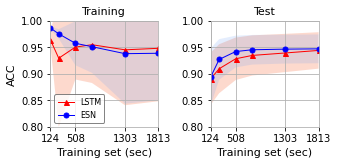

In [347]:
fig = plt.figure(figsize=(4.8, 2.4))

ax = fig.add_subplot(122)
axt = fig.add_subplot(121)

ax.plot(x, lstm_accs, label="LSTM", color="red", lw=1, marker="^", markersize=5)
ax.fill_between(x, np.array(lstm_accs) - np.array(lstm_stds), 
                 np.array(lstm_accs) + np.array(lstm_stds), alpha=0.2)
#ax.errorbar(x, lstm_accs, lstm_stds, color="red")

axt.plot(x, lstm_taccs, label="LSTM", color="red", lw=1, marker="^", markersize=5)
axt.fill_between(x, np.array(lstm_taccs) - np.array(lstm_tstds), 
                 np.array(lstm_taccs) + np.array(lstm_tstds), alpha=0.2)
#axt.errorbar(x, lstm_taccs, lstm_tstds, linestyle="--", color="red", marker="^")


ax.plot(x, esn_accs, color="blue", marker="o", lw=1, markersize=5)
ax.fill_between(x, np.array(esn_accs) - np.array(esn_stds), 
                 np.array(esn_accs) + np.array(esn_stds), alpha=0.2)
#ax.errorbar(x, esn_accs, esn_stds, color="blue")

axt.plot(x, esn_taccs, label="ESN", color="blue", lw=1, marker="o", markersize=5)
axt.fill_between(x, np.array(esn_taccs) - np.array(esn_tstds), 
                 np.array(esn_taccs) + np.array(esn_tstds), alpha=0.2)
#axt.errorbar(x, esn_taccs, esn_tstds, color="blue", linestyle="--")


ax.set_xticks([5, 20, 50, 70])
ax.set_xticklabels([mean_durations[i] for i in [0, 2, 4, 5]])
ax.set_yticks([0.70, 0.75, 0.80, 0.85, 0.9, 0.95, 1.0])
ax.tick_params(which="both", axis="both", labelsize=10)
ax.set_xlabel("Training set (sec)", size=11)
ax.set_title("Test", size=11)
ax.grid()


axt.set_xticks([5, 20, 50, 70])
axt.set_xticklabels([mean_durations[i] for i in [0, 2, 4, 5]])
axt.set_yticks([0.70, 0.75, 0.80, 0.85, 0.9, 0.95, 1.0])
axt.tick_params(which="both", axis="both", labelsize=10)
axt.set_title("Training", size=11)
axt.set_ylabel("ACC", size=11)
axt.set_xlabel("Training set (sec)", size=11)
axt.grid()

axt.legend(fontsize=8)

#axt.legend(bbox_to_anchor=[-1, -0.6, 0., 0.], ncol=2, fontsize=10)

axt.set_ylim(0.80, 1)
ax.set_ylim(0.80, 1)

fig.tight_layout()

fig.savefig("../figures/reduced_song_training.pdf")
fig.savefig("../figures/reduced_song_training.png")

# Output example

In [85]:
lstm_preds_files = glob.glob("../reports/marron1/lstm-2/cv/*/preds-2/*.npz")
esn_preds_files = glob.glob("../reports/marron1/esn-3/cv/*/preds-2/*.npz")

In [86]:
def get_wave_name(file):
    return Path(file).stem

lstm_preds_files = sorted(lstm_preds_files, key=get_wave_name)
esn_preds_files = sorted(esn_preds_files, key=get_wave_name)

lstm_waves = [get_wave_name(f) for f in lstm_preds_files]
esn_waves = [get_wave_name(f) for f in esn_preds_files]

In [87]:
matches = [w for w in esn_waves if w in lstm_waves]
matches

lstm_preds_files = [f for f in lstm_preds_files if get_wave_name(f) in matches]
esn_preds_files = [f for f in esn_preds_files if get_wave_name(f) in matches]

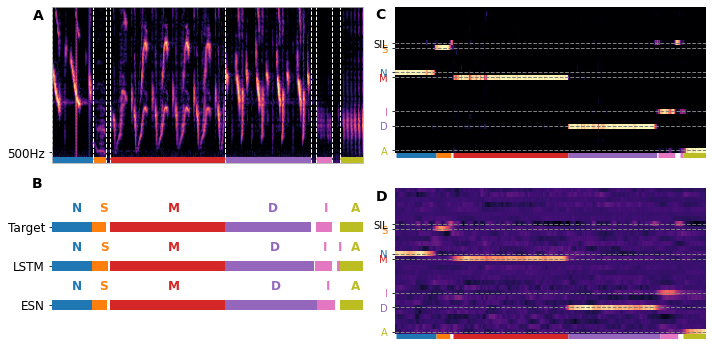

In [88]:
area = slice(850, 1150)
idx = 10
wave_file = matches[idx]
lpreds = np.load(lstm_preds_files[idx])
epreds = np.load(esn_preds_files[idx])

etarg = epreds["targets"]
ltarg = lpreds["targets"]

etop = epreds["top_1"]
ltop = lpreds["top_1"]

epred = epreds["pred"]
lpred = lpreds["pred"]

fig = plt.figure(figsize=(10, 5))

ax = fig.add_subplot(221)

wave = np.load(f"../data/processed/8kHz-13mfcc-2/marron1/{wave_file}.npz")["wave"]
spec = lbr.amplitude_to_db(np.abs(lbr.stft(
    wave, hop_length=512, win_length=1024, n_fft=2048)))

ax.imshow(spec[25:408, area], origin="lower", aspect="auto")

ax.set_xticks([])
ax.set_yticks([25, 408 - 25])
ax.set_yticklabels(["500Hz", "8kHz"])


ax3 = fig.add_subplot(222)
ax3.imshow(lpred[-epred.shape[0]:][area].T, aspect="auto", origin="lower", interpolation="nearest")
ax3.set_xticks([])
ax3.set_yticks([0, 5, 8, 15, 16, 21, 22])
ax3.set_yticklabels(["A", "D", "I", "M", "N", "S", "SIL"], size=10)
ax3.spines["top"].set_visible(False)
ax3.spines["bottom"].set_visible(False)
ax3.spines["left"].set_visible(False)
ax3.spines["right"].set_visible(False)

for y in [0, 5, 8, 15, 16, 21, 22]:
    ax3.axhline(y, color="gray", lw=1, linestyle="--")

ax4 = fig.add_subplot(224)
ax4.imshow(epred[area].T, aspect="auto", origin="lower", interpolation="nearest")
ax4.set_xticks([])
ax4.set_yticks([0, 5, 8, 15, 16, 21, 22])
ax4.set_yticklabels(["A", "D", "I", "M", "N", "S", "SIL"], size=10)
ax4.spines["top"].set_visible(False)
ax4.spines["bottom"].set_visible(False)
ax4.spines["left"].set_visible(False)
ax4.spines["right"].set_visible(False)

for y in [0, 5, 8, 15, 16, 21, 22]:
    ax4.axhline(y, color="gray", lw=1, linestyle="--")

ax2 = fig.add_subplot(223)
ax2.set_ylim(-0.5, 1.5)

palette = itertools.cycle(plt.get_cmap("tab10").colors)
colors = {"SIL": "white"}

cursor = 0
for k, seq in itertools.groupby(etarg[area]):
    c = colors.get(k, next(palette))
    colors[k] = c
    length = len(list(seq))
    
    ax2.hlines(1, cursor, cursor + length, color=c, lw=10)
    
    if k != "SIL":
        ax2.text(cursor + length / 2, 1.2, k, color=c, size=12, fontweight="bold")

        ax.axvline(cursor, color="white", linestyle="--", lw=1)
        ax.axvline(cursor + length, color="white", linestyle="--", lw=1)
    
        ax.hlines(1, cursor, cursor + length, color=c, lw=10)
    
    cursor += length
    
cursor = 0
for k, seq in itertools.groupby(ltop[area]):
    c = colors.get(k, next(palette))
    colors[k] = c
    length = len(list(seq))
    
    if k != "SIL":
        ax2.text(cursor + length / 2, 0.7, k, color=c, size=12, fontweight="bold")

    
    ax2.hlines(0.5, cursor, cursor + length, color=c, lw=10)

    ax3.hlines(-1, cursor, cursor + length, color=c, lw=5)
    
    cursor += length
    
    
cursor = 0
for k, seq in itertools.groupby(etop[area]):
    c = colors.get(k, next(palette))
    colors[k] = c
    length = len(list(seq))
    
        
    if k != "SIL":
        ax2.text(cursor + length / 2, 0.2, k, color=c, size=12, fontweight="bold")
    
    ax2.hlines(0, cursor, cursor + length, color=c, lw=10)

    ax4.hlines(-1, cursor, cursor + length, color=c, lw=5)
    
    cursor += length

ax2.spines["top"].set_visible(False)
ax2.spines["bottom"].set_visible(False)
ax2.spines["left"].set_visible(False)
ax2.spines["right"].set_visible(False)
ax2.set_xticks([])
ax2.set_yticks([1, 0.5, 0])
ax2.set_yticklabels(["Target", "LSTM", "ESN"])

colors["SIL"] = "black"
[label.set_color(colors[k]) for k, label in zip(["A", "D", "I", "M", "N", "S", "SIL"], ax3.get_yticklabels())]
[label.set_color(colors[k]) for k, label in zip(["A", "D", "I", "M", "N", "S", "SIL"], ax4.get_yticklabels())]


ax.text(-20, 350, "$\mathbf{A}$", size=14)
ax2.text(-20, 1.5, "$\mathbf{B}$", size=14)
ax3.text(-20, 27, "$\mathbf{C}$", size=14)
ax4.text(-20, 27, "$\mathbf{D}$", size=14)

plt.tight_layout()

fig.savefig("../figures/outputs.pdf")
fig.savefig("../figures/outputs.png")